In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
ph = pd.read_csv('ph2402.csv')
color = pd.read_csv('color.csv')
ph = ph.rename(columns = {'pH затора': 'PH of congestion',
                          'Орто фосфорная кислота/молочная, кг': 'Phosphoric acid, kg',
                          'Количество первого сусла, гл': 'First soul volume, gl',
                          'Кол-во холодного сусла, гл': 'Cooled wort volume, gl',
                          'Сульфат цинка, литр': 'Zinc sulfate volume, l'})






color = color.rename(columns = {'цветность сусла': 'wort color',
                                'Экстрактивность, % с.в.': 'Extractivity, %',
                                'Alpha Acid B Extr: CO2, кг': 'Alpha Acid B Extr: CO2, kg',
                                'Количество слабого сусла, гл': 'Weaker wort volume, gl' ,
                                'солод светлый итого, кг': 'Malt Light total, kg',
                                'жженый 900 ЕВС, кг':'Malt burned 900 ЕВС, kg',
                                '5. Время кипячения/процесса time': 'Brewing time',
                                'Расход пара кипячение, кг/гл': 'Steam consumption boiling, kg/gl',
                                'Пазуа - перекачка time': 'Pumping pause'})

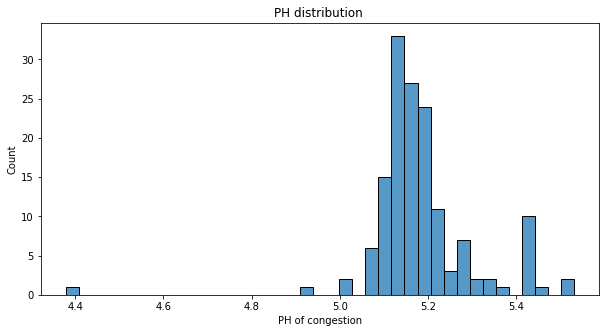

In [3]:
plt.figure(figsize = (10, 5))
plt.title('PH distribution ')
sns.histplot(ph['PH of congestion'])

In [4]:
def ph_norm(x):
    if 5.1 <= x <= 5.2:
        return 'normal'
    elif x < 5.1:
        return 'below normal'
    elif x > 5.2:
        return 'above normal'
    
def norma_color(x):
    if 10.5 <= x <= 13.0:
        return 'norm'
    elif x < 10.5:
        return 'below normal'
    elif x > 13.0:
        return 'above normal'
    
ph['Ph norm'] = ph['PH of congestion'].map(lambda x: ph_norm(x))
color['color norm'] = color['wort color'].map(lambda x: norma_color(x))

In [5]:
columns1 = ['Phosphoric acid, kg',
        'First soul volume, gl',
        'Cooled wort volume, gl',
        'Zinc sulfate volume, l', 'Ph norm']

columns2 = ['Extractivity, %',
'Alpha Acid B Extr: CO2, kg',
'Weaker wort volume, gl' ,
'Malt Light total, kg', 'wort color']

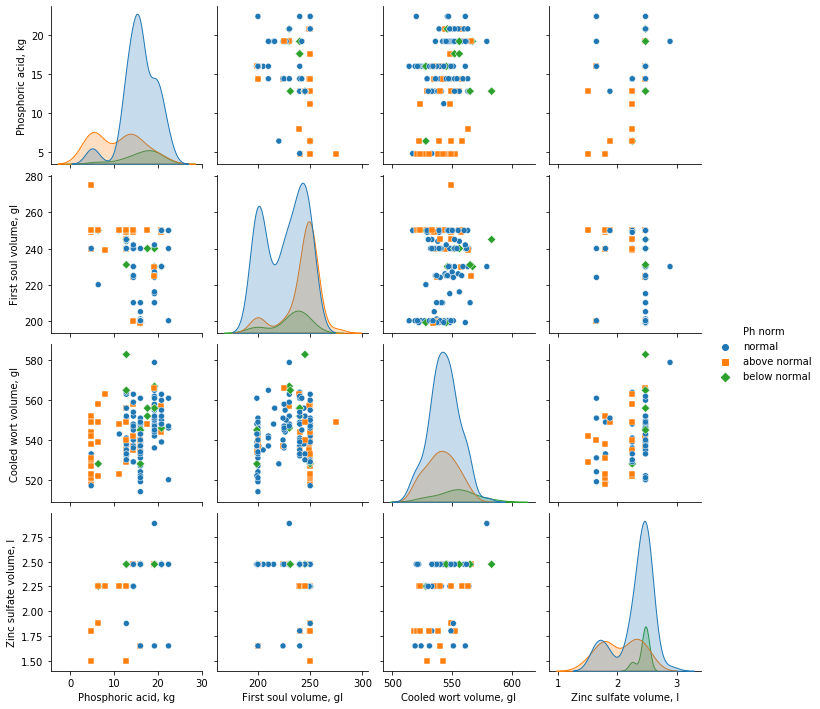

In [6]:
sns.pairplot(ph[columns1], hue="Ph norm", diag_kind = 'kde', markers=["o", "s", "D"])

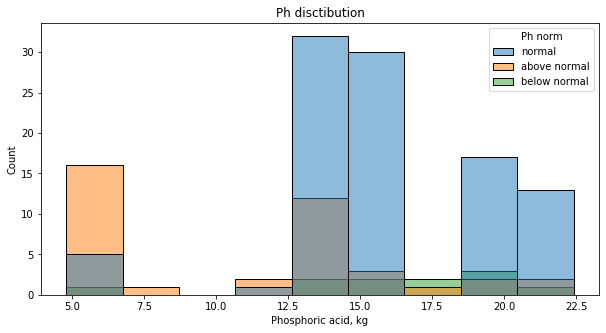

In [7]:
plt.figure(figsize = (10, 5))
plt.title('Ph disctibution')
sns.histplot(
    ph,
    x="Phosphoric acid, kg", hue="Ph norm",
    element = "bars")

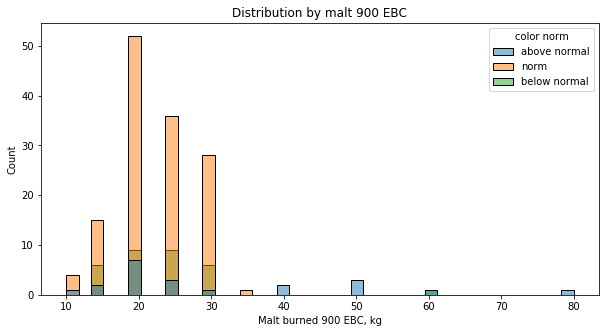

In [8]:
plt.figure(figsize = (10, 5))
plt.title('Distribution by malt 900 EBC')
sns.histplot(
    color,
    x='Malt burned 900 ЕВС, kg', hue="color norm",
    element = "bars")

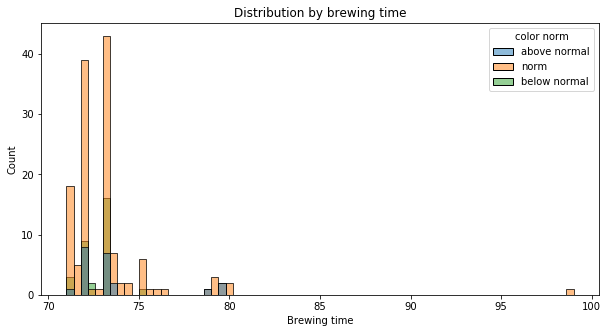

In [9]:
plt.figure(figsize = (10, 5))
plt.title('Distribution by brewing time')
sns.histplot(
    color,
    x='Brewing time', hue="color norm",
    element = "bars")

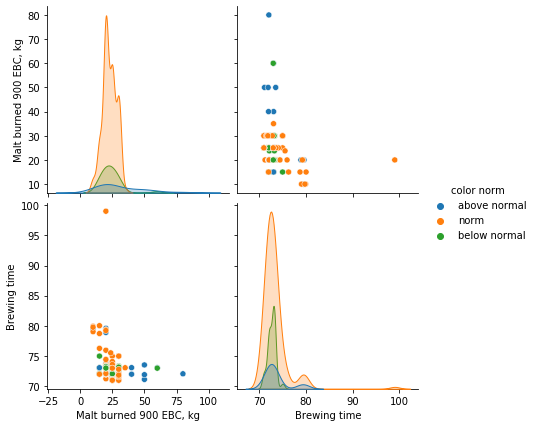

In [10]:
sns.pairplot(color[['Malt burned 900 ЕВС, kg', 'Brewing time', 'color norm']], hue="color norm", diag_kind = 'kde', size = 3)

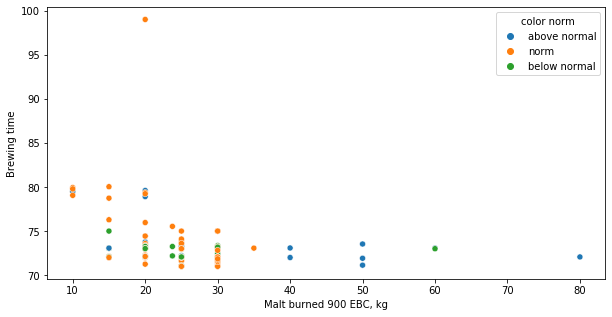

In [11]:
plt.figure(figsize = (10, 5))
sns.scatterplot(color['Malt burned 900 ЕВС, kg'], color['Brewing time'], hue = color['color norm'])

In [12]:
colors = sns.color_palette()
sns.set_palette(colors)

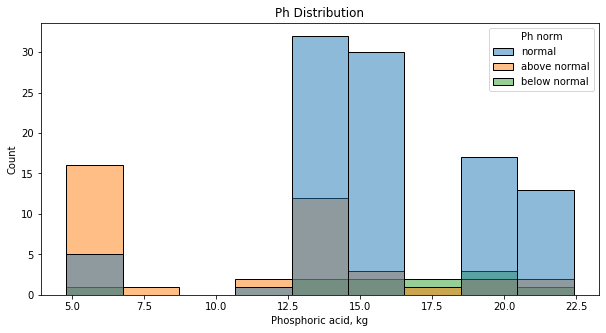

In [13]:
plt.figure(figsize = (10, 5))
plt.title('Ph Distribution')
sns.histplot(
    ph,
    x="Phosphoric acid, kg", hue="Ph norm",
    element = "bars",
    color = ['r', 'w', 'b'])

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=0, max_depth=2)

In [15]:
cross_val_score(clf, color.drop(['wort color', 'color norm'], axis = 1), color['color norm'], cv=10)

array([0.68421053, 0.78947368, 0.78947368, 0.21052632, 0.73684211,
       0.73684211, 0.31578947, 0.73684211, 0.72222222, 0.72222222])

In [16]:
clf.fit(color.drop(['wort color', 'color norm'], axis = 1), color['color norm'])
clf.score(color.drop(['wort color', 'color norm'], axis = 1), color['color norm'])

0.7712765957446809

In [17]:
df = pd.DataFrame()
df['feature_name'] = color.drop(['wort color', 'color norm'], axis = 1).columns
df['feature_importances_'] = clf.feature_importances_
df.sort_values('feature_importances_', ascending = False).head()

,feature_name,feature_importances_
34,"Malt burned 900 ЕВС, kg",0.591665
37,"Steam consumption boiling, kg/gl",0.296446
67,Pumping pause,0.111888
3,4. Контроль температуры под вальцами,0.000000
36,"Расход пара, нагрев кг/гл",0.000000


In [18]:
clf.get_n_leaves()

4

In [19]:
from sklearn import tree
feature_names = list(color.drop(['wort color', 'color norm'], axis = 1).columns)
text_representation = tree.export_text(clf, feature_names=feature_names)
print(text_representation)

|--- Malt burned 900 ЕВС, kg <= 37.50
|   |--- Steam consumption boiling, kg/gl <= 2675.00
|   |   |--- class: below normal
|   |--- Steam consumption boiling, kg/gl >  2675.00
|   |   |--- class: norm
|--- Malt burned 900 ЕВС, kg >  37.50
|   |--- Pumping pause <= 9.11
|   |   |--- class: below normal
|   |--- Pumping pause >  9.11
|   |   |--- class: above normal



In [20]:
color.groupby('color norm')['nProtokolNo'].count()

color norm
above normal     21
below normal     31
norm            136
Name: nProtokolNo, dtype: int64

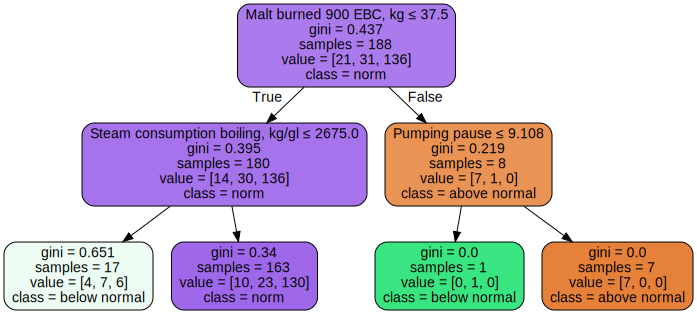

In [21]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=feature_names,  
                     class_names=['above normal', 'below normal', 'norm'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

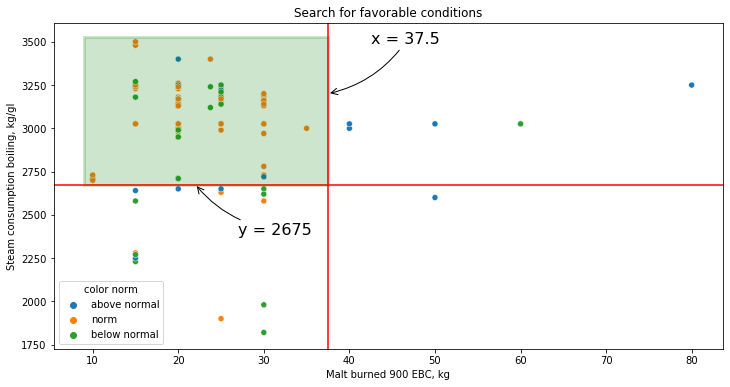

In [22]:
import matplotlib.patches as patches

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1,1,1,)

#ax.title = 'Показания параметров'
rect = patches.Rectangle((9, 2675), 28.5, 850, linewidth=3, edgecolor='g', facecolor='green', alpha = 0.2)

ax.set_title('Search for favorable conditions')
#plt.hlines(13, 0, 190, colors='k')
#plt.hlines(10.5, 0, 22, colors='r')
ax.axvline(37.5, color='r')
ax.axhline(2675, color='r')
#plt.axhline(1.2, color='r')
ax.add_patch(rect)

ax.annotate('x = 37.5 ',
             xy = (37.5, 3200), 
             xytext = (37.5 + 5,  50), 
             textcoords = 'offset points', 
             fontsize = 16,
             arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=-.2")
           )


ax.annotate('y = 2675 ',
             xy = (22, 2675), 
             xytext = (37.5 + 5,  - 50), 
             textcoords = 'offset points', 
             fontsize = 16,
             arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=-.2")
           )


sns.scatterplot(color['Malt burned 900 ЕВС, kg'], color['Steam consumption boiling, kg/gl'], hue = color['color norm'], ax = ax)

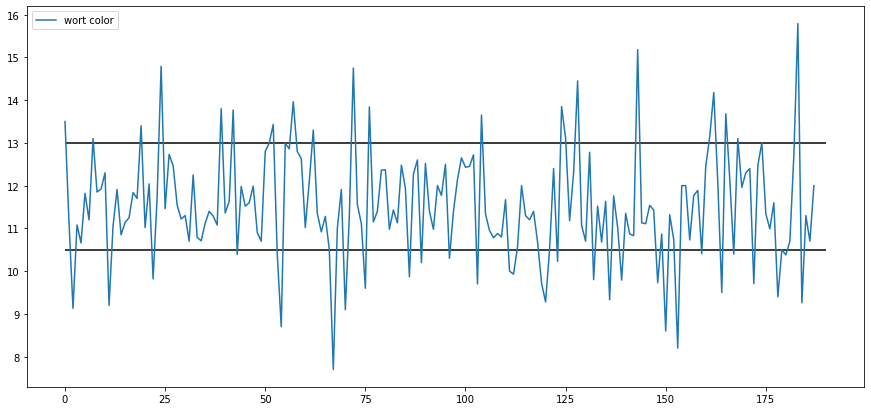

In [23]:
color[['wort color']].plot(figsize = (15 , 7))
plt.hlines(13, 0, 190, colors='k')
plt.hlines(10.5, 0, 190, colors='k')

In [81]:
ph = pd.read_csv('ph2402.csv')
ph = ph.rename(columns = {'pH затора': 'PH of congestion',
                          'Орто фосфорная кислота/молочная, кг': 'Phosphoric acid, kg',
                          'Количество первого сусла, гл': 'First soul volume, gl',
                          'Кол-во холодного сусла, гл': 'Cooled wort volume, gl',
                          'Сульфат цинка, литр': 'Zinc sulfate volume, l'})


def ph_norm(x):
    if 5.1 <= x <= 5.2:
        return 'normal'
    elif x < 5.1:
        return 'below normal'
    elif x > 5.2:
        return 'above normal'

ph['Ph norm'] = ph['PH of congestion'].map(lambda x: ph_norm(x))

In [87]:
clf = DecisionTreeClassifier(random_state=0, max_depth=2)
ph = ph.fillna(0)
cross_val_score(clf, ph.drop(['PH of congestion', 'Ph norm', 'norma_ph', 'Затирание дата'], axis = 1), ph['Ph norm'], cv=10)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [83]:
ph.groupby('Ph norm')['nProtokolNo'].count()

Ph norm
above normal    39
below normal    11
normal          98
Name: nProtokolNo, dtype: int64

In [84]:
clf.fit(ph.drop(['PH of congestion', 'Ph norm',
                 'nProtokolNo', 'norma_ph', 'Затирание дата',
                   'Плотность слабого сусла, % PL', 
                   'Ph norm'], axis = 1), ph['Ph norm'])

ValueError: could not convert string to float: '2019-08-30 02:13:00'

In [85]:
ph[ph == '2019-08-29 18:10:00'].any().sort_values()

year                                          False
№ танка/ Batch                                False
Охлаждение сусла, дата                        False
Пазуа - перекачка_time                        False
Пазуа - осахаривание_time                     False
                                              ...  
6. дозация добавок - ортофосфорная кислота    False
3. дозация добавок - хлорид кальция           False
1. Количество первого сусла_time              False
Ph norm                                       False
Затирание дата                                 True
Length: 76, dtype: bool

In [116]:
clf.score(ph.drop(['PH of congestion', 'Ph norm', 'nProtokolNo', 'Плотность слабого сусла, % PL'], axis = 1), ph['Ph norm'])

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [50]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 

In [51]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=feature_names,  
                     class_names=['меньше', 'больше', 'норма'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

ValueError: Length of feature_names, 68 does not match number of features, 66

# Для PH

In [52]:
ph = pd.read_csv('ph.csv')

def Ph norm(x):
    if 5.1 <= x <= 5.2:
        return 'норма'
    elif x < 5.1:
        return 'меньше'
    elif x > 5.2:
        return 'больше'
    
ph['Ph norm'] = ph['PH of congestion'].map(lambda x: Ph norm(x))

clf = DecisionTreeClassifier(random_state=0, max_depth=2)
cross_val_score(clf, ph.drop(['PH of congestion', 'Ph norm', 'norma_ph'], axis = 1), ph['Ph norm'], cv=10)

array([0.73333333, 0.8       , 0.66666667, 0.66666667, 0.73333333,
       0.4       , 0.6       , 0.26666667, 0.73333333, 0.6       ])

In [53]:
ph.groupby('Ph norm')['nProtokolNo'].count()

norma_ph
больше    40
меньше    11
норма     99
Name: nProtokolNo, dtype: int64

In [54]:
drop_columns = ['PH of congestion', 'Ph norm', 'nProtokolNo', 'Плотность слабого сусла, % PL',
                '1. Контроль количества воды - объем, который пошел на затирание time', 'Объем слабого сусла',
               '3. Количество воды на промывку time', '2. Температура воды на промывку time']

X = ph.drop(drop_columns, axis = 1)
X = X[['Орто фосфорная кислота/молочная, кг', 'Расход пара, нагрев кг/гл']]
y = ph['Ph norm']
clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [55]:
df = pd.DataFrame()
feature_names = ph.drop(drop_columns, axis = 1).columns
feature_names = ['Орто фосфорная кислота/молочная, кг', 'Расход пара, нагрев кг/гл']
df['feature_name'] = feature_names
df['feature_importances_'] = clf.feature_importances_

In [56]:
df.sort_values("feature_importances_", ascending = False)['feature_name'].values[1]

'Расход пара, нагрев кг/гл'

In [57]:
clf.score(X, y)

0.76

In [58]:
ph.groupby('Ph norm')['nProtokolNo'].count()

norma_ph
больше    40
меньше    11
норма     99
Name: nProtokolNo, dtype: int64

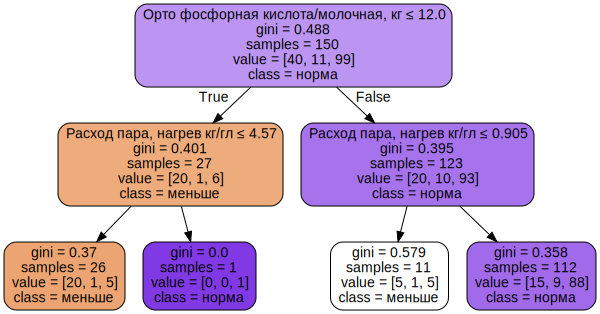

In [59]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=feature_names,  
                     class_names=['меньше', 'больше', 'норма'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [60]:
ph = pd.read_csv('ph.csv')

def Ph norm(x):
    if 5.1 <= x <= 5.2:
        return 'норма'
    elif x < 5.1:
        return 'меньше'
    elif x > 5.2:
        return 'больше'
    
ph['Ph norm'] = ph['PH of congestion'].map(lambda x: Ph norm(x))

clf = DecisionTreeClassifier(random_state=0, max_depth=5)
cross_val_score(clf, ph.drop(['PH of congestion', 'Ph norm'], axis = 1), ph['Ph norm'], cv=10)

X = ph[['Орто фосфорная кислота/молочная, кг', 'Steam consumption boiling, kg/gl']]
y = ph['Ph norm']
clf.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [61]:
df = pd.DataFrame()
feature_names = ['Орто фосфорная кислота/молочная, кг', 'Steam consumption boiling, kg/gl']
df['feature_name'] = feature_names
df['feature_importances_'] = clf.feature_importances_

In [62]:
df

,feature_name,feature_importances_
0,"Орто фосфорная кислота/молочная, кг",0.606859
1,"Расход пара кипячение, кг/гл",0.393141


In [63]:
tree.export_graphviz?

Signature:
tree.export_graphviz(
    decision_tree,
    out_file=None,
    *,
    max_depth=None,
    feature_names=None,
    class_names=None,
    label='all',
    filled=False,
    leaves_parallel=False,
    impurity=True,
    node_ids=False,
    proportion=False,
    rotate=False,
    rounded=False,
    special_characters=False,
    precision=3,
)
Docstring:
Export a decision tree in DOT format.

This function generates a GraphViz representation of the decision tree,
which is then written into `out_file`. Once exported, graphical renderings
can be generated using, for example::

    $ dot -Tps tree.dot -o tree.ps      (PostScript format)
    $ dot -Tpng tree.dot -o tree.png    (PNG format)

The sample counts that are shown are weighted with any sample_weights that
might be present.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
decision_tree : decision tree classifier
    The decision tree to be exported to GraphViz.

out_file : object or str, default=None
    Ha

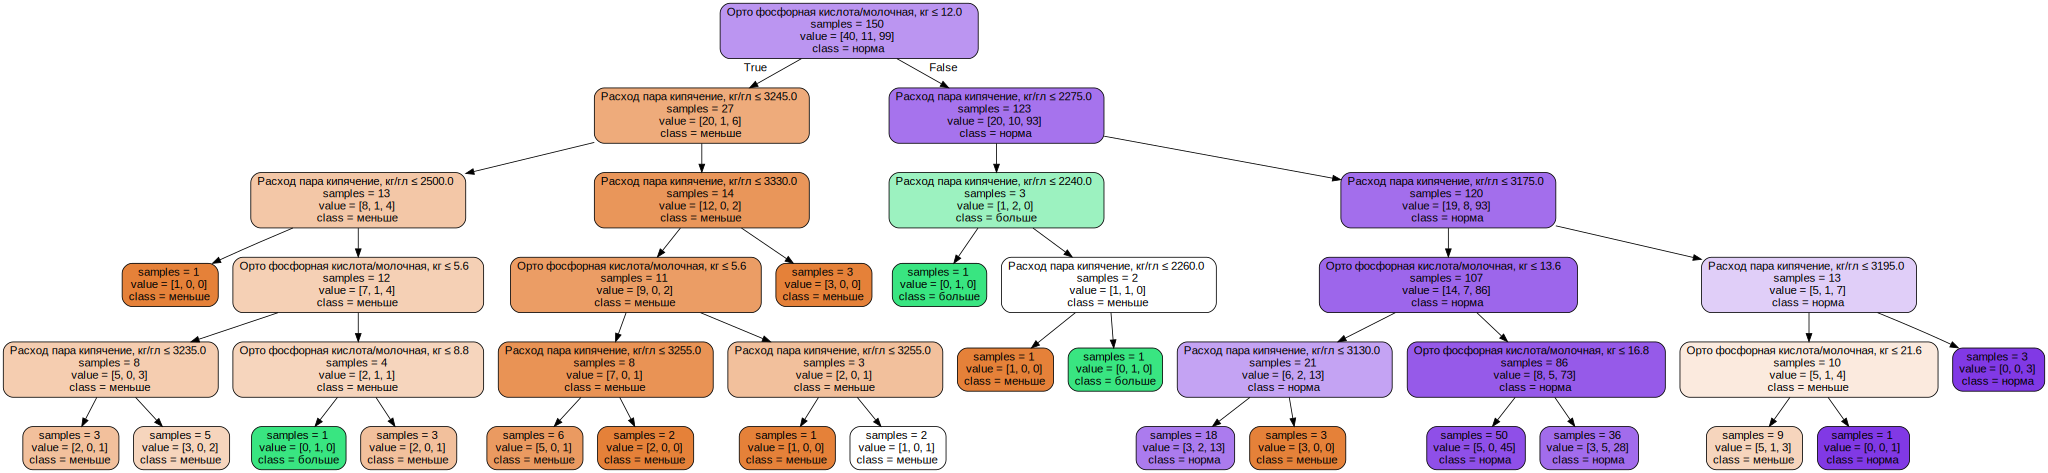

In [64]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=feature_names,  
                     class_names=['меньше', 'больше', 'норма'],  
                     filled=True, rounded=True,  
                     special_characters=True, impurity=False)  
graph = graphviz.Source(dot_data)  
graph 

In [317]:
2275-3175

-900

In [293]:
93/120

0.775

In [298]:
86/107

0.8037383177570093

In [307]:
45/50

0.9

In [310]:
from sklearn import tree
feature_names = list(feature_names)
text_representation = tree.export_text(clf, feature_names=feature_names)
print(text_representation)

|--- Орто фосфорная кислота/молочная, кг <= 12.00
|   |--- Расход пара кипячение, кг/гл <= 3245.00
|   |   |--- Расход пара кипячение, кг/гл <= 2500.00
|   |   |   |--- class: больше
|   |   |--- Расход пара кипячение, кг/гл >  2500.00
|   |   |   |--- Орто фосфорная кислота/молочная, кг <= 5.60
|   |   |   |   |--- Расход пара кипячение, кг/гл <= 3235.00
|   |   |   |   |   |--- class: больше
|   |   |   |   |--- Расход пара кипячение, кг/гл >  3235.00
|   |   |   |   |   |--- class: больше
|   |   |   |--- Орто фосфорная кислота/молочная, кг >  5.60
|   |   |   |   |--- Орто фосфорная кислота/молочная, кг <= 8.80
|   |   |   |   |   |--- class: меньше
|   |   |   |   |--- Орто фосфорная кислота/молочная, кг >  8.80
|   |   |   |   |   |--- class: больше
|   |--- Расход пара кипячение, кг/гл >  3245.00
|   |   |--- Расход пара кипячение, кг/гл <= 3330.00
|   |   |   |--- Орто фосфорная кислота/молочная, кг <= 5.60
|   |   |   |   |--- Расход пара кипячение, кг/гл <= 3255.00
|   |   | 

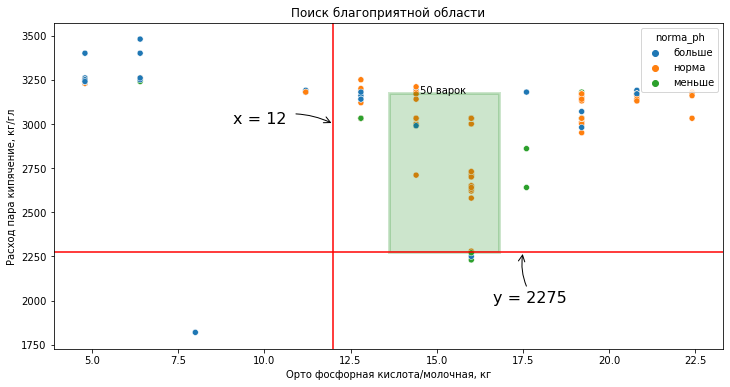

In [343]:
import matplotlib.patches as patches

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1,1,1,)

#ax.title = 'Показания параметров'
rect = patches.Rectangle((13.6, 2275), 3.2, 900, linewidth=3, edgecolor='g', facecolor='green', alpha = 0.2)

ax.set_title('Поиск благоприятной области')
#plt.hlines(13, 0, 190, colors='k')
#plt.hlines(10.5, 0, 22, colors='r')
ax.axvline(12, color='r')
ax.axhline(2275, color='r')
#plt.axhline(1.2, color='r')
#ax.axhline(1.54, color='r')

ax.add_patch(rect)

ax.annotate('x = 12 ',
             xy = (12, 3000), 
             xytext = (-100,  + 1), 
             textcoords = 'offset points', 
             fontsize = 16,
             arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=-.2")
           )


ax.annotate('y = 2275 ',
             xy = (17.5, 2275), 
             xytext = (-30,  -50), 
             textcoords = 'offset points', 
             fontsize = 16,
             arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=-.2")
           )

ax.text(14.5, 3175,'50 варок')



sns.scatterplot(ph['Орто фосфорная кислота/молочная, кг'], ph['Steam consumption boiling, kg/gl'], hue = ph['Ph norm'], ax = ax)

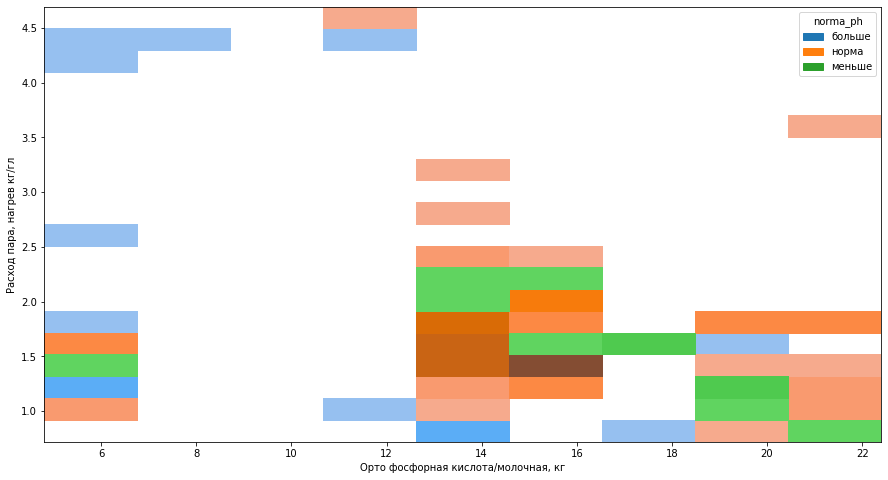

In [173]:
plt.figure(figsize = (15, 8))
sns.histplot(data = ph, 
             x = 'Орто фосфорная кислота/молочная, кг', 
             y = 'Расход пара, нагрев кг/гл', 
            hue = 'Ph norm')

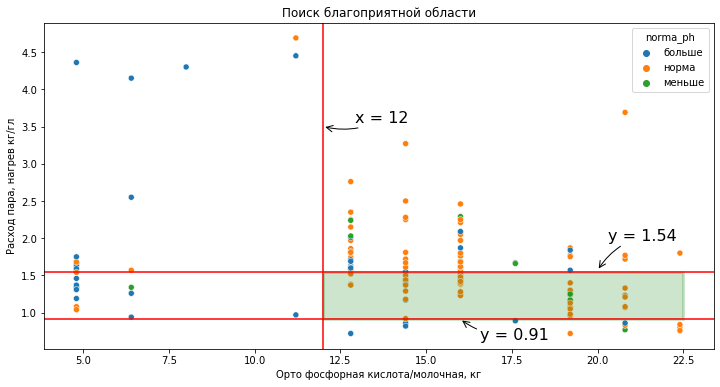

In [282]:
import matplotlib.patches as patches

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1,1,1,)

#ax.title = 'Показания параметров'
rect = patches.Rectangle((12, 0.91), 10.5, 0.63, linewidth=3, edgecolor='g', facecolor='green', alpha = 0.2)

ax.set_title('Поиск благоприятной области')
#plt.hlines(13, 0, 190, colors='k')
#plt.hlines(10.5, 0, 22, colors='r')
ax.axvline(12, color='r')
ax.axhline(0.91, color='r')
#plt.axhline(1.2, color='r')
ax.axhline(1.54, color='r')
ax.add_patch(rect)

ax.annotate('x = 12 ',
             xy = (12, 3.5), 
             xytext = (12 + 20,  3 + 1), 
             textcoords = 'offset points', 
             fontsize = 16,
             arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=-.2")
           )


ax.annotate('y = 1.54 ',
             xy = (20, 1.57), 
             xytext = (10 ,  30), 
             textcoords = 'offset points', 
             fontsize = 16,
             arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=.2")
           )


ax.annotate('y = 0.91 ',
             xy = (16, 0.91), 
             xytext = (20 ,  - 20), 
             textcoords = 'offset points', 
             fontsize = 16,
             arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=-.2")
           )



sns.scatterplot(ph['Орто фосфорная кислота/молочная, кг'], ph['Расход пара, нагрев кг/гл'], hue = ph['Ph norm'], ax = ax)

In [156]:
108/(7+3+108)

0.9152542372881356

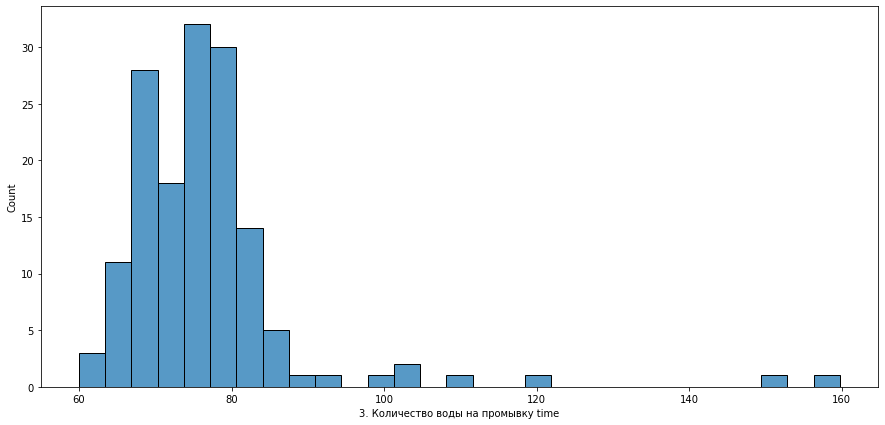

In [66]:
plt.figure(figsize = (15 , 7))
sns.histplot(ph['3. Количество воды на промывку time'])